In [1]:
import sys 
sys.path.append('../')

In [3]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import MaskRCNN
import torchvision.models.detection.backbone_utils #import _resnet_fpn_extractor
import torch.nn as nn

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [4]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load train and validation data 

grape - f
crump - f
pea_(food) - c
peach - c
apricot - r
crouton - r

In [6]:
time_start = time.time()

data_args = {'stage': 'train',
            'classes': ['grape', 'crumb', 'pea_(food)', 'peach', 'apricot', 'crouton'],
             #['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], # ['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 0}
train_data = dataset_lvis.LVISData(**data_args)

print(f'Time taken to initialize train set: {time.time()-time_start}')

classes : {1: 'apricot', 2: 'crouton', 3: 'crumb', 4: 'grape', 5: 'pea_(food)', 6: 'peach'}
loaded 628 positive set images
loaded 0 negative set images
loaded 341 non-exhaustive set images
Loaded 287 images!
class 1 has 10 positive and 0 negative images
class 2 has 7 positive and 0 negative images
class 3 has 101 positive and 0 negative images
class 4 has 101 positive and 0 negative images
class 5 has 31 positive and 0 negative images
class 6 has 47 positive and 0 negative images
3283 annotations found!
stage:  train
classes:  {'apricot': 14, 'crouton': 331, 'crumb': 338, 'grape': 510, 'pea_(food)': 773, 'peach': 774}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize train set: 31.746514797210693


### Split train set into custom train val set

Validation set reserved for testing

Check that we don't have too many of the rare cases in validation set - if so then there won't be much data to actually train on.

In [7]:
# what images have what classes?
g_cpu = torch.Generator()
g_cpu.manual_seed(42)

#Split dataset to test and train
indices = torch.randperm(len(train_data), generator=g_cpu).tolist()


dataset_train = torch.utils.data.Subset(train_data, indices[:260])
dataset_val = torch.utils.data.Subset(train_data, indices[260:])


class_counts = dict(zip(range(1,7), [0]*6))
for _, _, y in dataset_val:
    for label in y['labels']:
        class_counts[label.item()] += 1
            
class_counts

{1: 0, 2: 0, 3: 55, 4: 198, 5: 79, 6: 27}

## Prepare test set

The LVIS validation set is reserved for our test set

In [8]:
time_start = time.time() 
data_args = {'stage': 'val',
            'classes':  ['grape', 'crumb', 'pea_(food)', 'peach', 'apricot', 'crouton'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 200}   # note that we include negative sets for the testing
val_data = dataset_lvis.LVISData(**data_args)
print(f'Time taken to initialize val set: {time.time()-time_start}')

classes : {1: 'apricot', 2: 'crouton', 3: 'crumb', 4: 'grape', 5: 'pea_(food)', 6: 'peach'}
loaded 117 positive set images
loaded 887 negative set images
loaded 59 non-exhaustive set images
Loaded 942 images!
class 1 has 0 positive and 119 negative images
class 2 has 3 positive and 140 negative images
class 3 has 18 positive and 124 negative images
class 4 has 22 positive and 174 negative images
class 5 has 7 positive and 181 negative images
class 6 has 9 positive and 169 negative images
791 annotations found!
stage:  val
classes:  {'apricot': 14, 'crouton': 331, 'crumb': 338, 'grape': 510, 'pea_(food)': 773, 'peach': 774}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize val set: 3.6889147758483887


# Fine-tuning the model

Here we set `pretrained = True` for the FPN: FPN is pre-trained on coco dataset. We keep the backbone ResNet50 pretrained on ImageNet.

In [10]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    anchor_generator = AnchorGenerator(sizes=((2,4,8,16,32,64),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
    
    backbone = torchvision.models.resnet50(pretrained = True)
    modules = list(backbone.children())[:-2]
    backbone = nn.Sequential(*modules)
    backbone.out_channels = 2048

    
    model = MaskRCNN(backbone,  num_classes=num_classes, rpn_anchor_generator=anchor_generator)
    

    return model

# Set up DataLoaders

In [11]:

train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=5, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

val_loader = torch.utils.data.DataLoader(
 dataset_val, batch_size=5, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


# Initialize Model + Model params

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 7 classes - background and 6 specified objects
num_classes = 7

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model

In [13]:
num_epochs = 31
time_start = time.time() 


train_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
val_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])

loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss']


for epoch in range(num_epochs):
    model.train()
    
    train_loss = dict.fromkeys(loss_types, 0) 
    val_loss = dict.fromkeys(loss_types, 0) 
    
    """
    Train 
    """
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        losses = sum(loss for loss in loss_dict.values())
        
        #save losses
        for key in loss_types:
            if key != 'total_loss':
                train_loss[key] += loss_dict[key].item()
            else: 
                train_loss['total_loss'] += losses.item()
                

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [train_loss['loss_classifier']/(batch_num+1)],
          'loss_box_reg' : [train_loss['loss_box_reg']/(batch_num+1)],
           'loss_mask': [train_loss['loss_mask']/(batch_num+1)],
           'loss_objectness': [train_loss['loss_objectness']/(batch_num+1)],
           'loss_rpn_box_reg': [train_loss['loss_rpn_box_reg']/(batch_num+1)],
            'total_loss': [train_loss['total_loss']/(batch_num+1)] 
          })     

    train_loss_df = pd.concat([train_loss_df, row], ignore_index = True, axis = 0)
    
    print(f"Training loss after {epoch} epochs: {train_loss['total_loss']}")

    
    """
    Validation
    """
    with torch.no_grad():
        for batch_num, (idx, X, y) in enumerate(val_loader):
            #X = X.to(device)
            X = list(image.to(device) for image in X)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            loss_dict = model(X, y) 
            
            losses_val = sum(loss for loss in loss_dict.values())
            
            #save losses
            for key in loss_types:
                if key != 'total_loss':
                    val_loss[key] += loss_dict[key].item()
                else: 
                    val_loss['total_loss'] += losses_val.item()
                    
        row = pd.DataFrame({'epoch': [epoch],
                          'loss_classifier': [val_loss['loss_classifier']/(batch_num+1)],
                          'loss_box_reg' : [val_loss['loss_box_reg']/(batch_num+1)],
                           'loss_mask': [val_loss['loss_mask']/(batch_num+1)],
                           'loss_objectness': [val_loss['loss_objectness']/(batch_num+1)],
                           'loss_rpn_box_reg': [val_loss['loss_rpn_box_reg']/(batch_num+1)],
                            'total_loss': [val_loss['total_loss']/(batch_num+1)] 
                          })
        val_loss_df = pd.concat([val_loss_df, row], ignore_index = True, axis = 0)

    print(f"Validation loss after {epoch} epochs: {val_loss['total_loss']}") 
    print(f'Time elapsed for {epoch} epochs: {time.time()-time_start}') 

      
    """
    Save checkpoints and losses every 5 epoch
    """
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch,
                        "ds_args" : data_args
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        helper.save_checkpoint(checkpoint, fname)
        print(f'Time elapsed after {epoch} epochs: {time.time()-time_start}')  
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))

    
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss after 0 epochs: 80.18555963039398
Validation loss after 0 epochs: 7.031113028526306
Time elapsed for 0 epochs: 58.33443021774292
Saved checkpoint model_0_epochs.pth!
Time elapsed after 0 epochs: 60.978517055511475
Training loss after 1 epochs: 55.97984820604324
Validation loss after 1 epochs: 7.121787011623383
Time elapsed for 1 epochs: 118.44824862480164
Training loss after 2 epochs: 54.987227737903595
Validation loss after 2 epochs: 6.979370653629303
Time elapsed for 2 epochs: 177.2288806438446
Training loss after 3 epochs: 52.83159041404724
Validation loss after 3 epochs: 6.572754442691803
Time elapsed for 3 epochs: 235.97737550735474
Training loss after 4 epochs: 51.00894057750702
Validation loss after 4 epochs: 6.041672587394714
Time elapsed for 4 epochs: 294.89061188697815
Training loss after 5 epochs: 49.70760375261307
Validation loss after 5 epochs: 6.6617544293403625
Time elapsed for 5 epochs: 354.34626817703247
Saved checkpoint model_5_epochs.pth!
Time elapsed a

# Plot loss 

<AxesSubplot:>

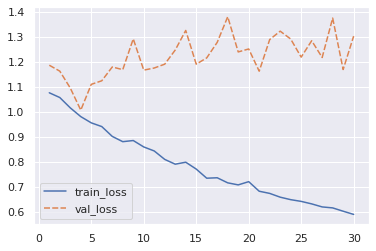

In [14]:
new_df = pd.DataFrame() 
#new_df['epoch'] = train_loss_df['epoch'] 
new_df['train_loss'] = train_loss_df['total_loss'] 
new_df['val_loss'] = val_loss_df['total_loss'] 

sns.lineplot(data = new_df[1:])
#new_df


# Calculate mAP on train set


In [15]:
importlib.reload(metrics)

<module 'src.metrics' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/metrics.py'>

In [16]:
num_classes = 7

#model setup 
model = get_instance_segmentation_model(num_classes)
model.to(device)

helper.load_model(model, 'model.pth')


Loaded from model model.pth!


In [17]:
train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

In [18]:
#mAP but not calculated as per fed set since there's no negative set 
pred_boxes =[]
gt =[] 

for idx,X, y in train_loader:
    model.eval()
    y_pred = model(X.to(device)) 
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred, pred_boxes, gt)

In [19]:
mAP_list = [] 
ap_list = []

thresholds= np.arange(0.5, 1, 0.05) #0.5 -0.95
for iou_thres in thresholds:
    mAP, AP = metrics.calculate_ap(pred_boxes, gt, train_data.class_datasets, iou_threshold = iou_thres)
    mAP_list.append(mAP) 
    ap_list.append(AP)

In [20]:
class_names = {} 
for key, val in train_data.class_idx_map.items() :
    for k, v in train_data.classes.items():
        if key == v:
            class_names[val] = k
print(class_names)
    

{1: 'apricot', 2: 'crouton', 3: 'crumb', 4: 'grape', 5: 'pea_(food)', 6: 'peach'}


## Average Precision

[Text(0.5, 1.0, 'Average Precision by IOU Threshold (train)')]

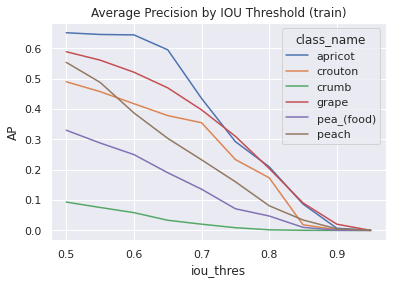

In [21]:
df_AP = pd.DataFrame(columns = ["iou_thres", "class_name", "AP"])

for idx, class_aps in enumerate(ap_list):
    iou_thres = thresholds[idx]
    for key, val in class_aps.items():
        class_name = class_names[key] 

        row = pd.DataFrame({"iou_thres": [iou_thres],
               "class_name": [class_name],
               "AP": [val.item()]
              })
        df_AP = pd.concat([df_AP, row], axis = 0, ignore_index = True)
        
df_AP.head()
sns.lineplot(data= df_AP, x="iou_thres", y="AP", hue = "class_name").set(title="Average Precision by IOU Threshold (train)")

## mean Average Precision 

[Text(0.5, 1.0, 'mAP (train)')]

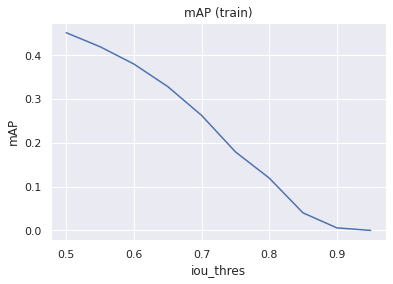

In [22]:
df_mAP = pd.DataFrame(columns = ["iou_thres", "mAP"])

for idx, mAP in enumerate(mAP_list):
    row = pd.DataFrame({"iou_thres":[thresholds[idx]],
                        "mAP": [mAP_list[idx].item()]})
    df_mAP = pd.concat([df_mAP, row], axis = 0, ignore_index = True) 
    
#df_mAP    
    
sns.lineplot(data = df_mAP, x ="iou_thres", y="mAP").set(title = "mAP (train)")

# Calculate mAP on test set

In [23]:
test_loader = torch.utils.data.DataLoader(
 val_data, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


In [24]:
pred_boxes =[]
gt =[] 

for idx,X, y in test_loader:
    model.eval()
    y_pred = model(X.to(device)) 
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred, pred_boxes, gt)

In [25]:
mAP_list = [] 
ap_list = []

thresholds= np.arange(0.5, 1, 0.05) #0.5 -0.95
for iou_thres in thresholds:
    mAP, AP = metrics.calculate_ap(pred_boxes, gt, iou_threshold = iou_thres, class_datasets = val_data.class_datasets)
    mAP_list.append(mAP) 
    ap_list.append(AP)

In [26]:
class_names = {} 
for key, val in val_data.class_idx_map.items() :
    for k, v in val_data.classes.items():
        if key == v:
            class_names[val] = k
print(class_names)
    

{1: 'apricot', 2: 'crouton', 3: 'crumb', 4: 'grape', 5: 'pea_(food)', 6: 'peach'}


## calculate AP on train set

[Text(0.5, 1.0, 'Average Precision by IOU Threshold')]

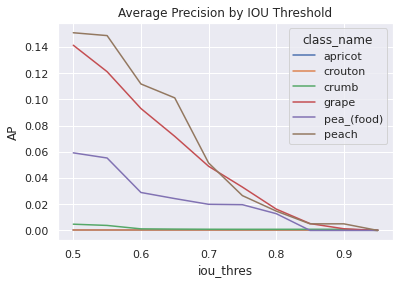

In [27]:
df_AP = pd.DataFrame(columns = ["iou_thres", "class_name", "AP"])

for idx, class_aps in enumerate(ap_list):
    iou_thres = thresholds[idx]
    for key, val in class_aps.items():
        class_name = class_names[key] 

        row = pd.DataFrame({"iou_thres": [iou_thres],
               "class_name": [class_name],
               "AP": [val.item()]
              })
        df_AP = pd.concat([df_AP, row], axis = 0, ignore_index = True)
        
df_AP.head()
sns.lineplot(data= df_AP, x="iou_thres", y="AP", hue = "class_name").set(title="Average Precision by IOU Threshold")

In [28]:
grape - f
crump - f
pea_(food) - c
peach - c
apricot - r
crouton - r

NameError: name 'grape' is not defined

[Text(0.5, 1.0, 'Average Precision by IOU Threshold')]

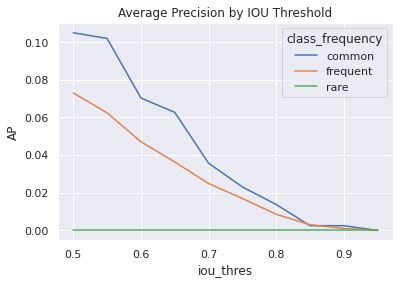

In [29]:
class_frequency_dict = {'grape': 'frequent', 'crumb': 'frequent', 'pea_(food)': 'common', 
                        'peach': 'common', 'apricot': 'rare', 'crouton': 'rare'}


#{'cappuccino': 'common', 'chessboard': 'rare',  'coffee_maker':'frequent', 
#                        'cowboy_hat':'frequent', 'drumstick':'rare', 'monkey':'common'}

df_AP_freq = df_AP
df_AP_freq['class_frequency'] = df_AP_freq['class_name'].map(class_frequency_dict)
temp = df_AP_freq.groupby(by= ["iou_thres", "class_frequency"])['AP'].mean().reset_index()
sns.lineplot(data= temp, x="iou_thres", y="AP", hue = "class_frequency").set(title="Average Precision by IOU Threshold")

In [30]:
temp

,iou_thres,class_frequency,AP
0,0.50,common,0.105029
1,0.50,frequent,0.073043
2,0.50,rare,0.000000
3,0.55,common,0.101976
4,0.55,frequent,0.062475
5,0.55,rare,0.000000
6,0.60,common,0.070358
7,0.60,frequent,0.047108
8,0.60,rare,0.000000
9,0.65,common,0.062729


## calculate mAP on train set

[Text(0.5, 1.0, 'mAP (test)')]

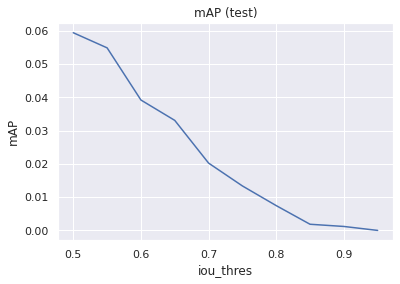

In [31]:
df_mAP = pd.DataFrame(columns = ["iou_thres", "mAP"])

for idx, mAP in enumerate(mAP_list):
    row = pd.DataFrame({"iou_thres":[thresholds[idx]],
                        "mAP": [mAP_list[idx].item()]})
    df_mAP = pd.concat([df_mAP, row], axis = 0, ignore_index = True) 
    
#df_mAP    
    
sns.lineplot(data = df_mAP, x ="iou_thres", y="mAP").set(title = "mAP (test)")

In [32]:
df_mAP

,iou_thres,mAP
0,0.5,0.059357
1,0.55,0.054817
2,0.6,0.039156
3,0.65,0.033043
4,0.7,0.020221
5,0.75,0.013359
6,0.8,0.007451
7,0.85,0.001851
8,0.9,0.001189
9,0.95,0.0
